In [1]:
import pandas as pd
#import seaborn as sns
import numpy as np
import re

from textwrap import wrap
from utils import *
from matplotlib import pyplot as plt
from pymongo import MongoClient
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.kernel_approximation import (RBFSampler, Nystroem)
from sklearn import metrics

In [208]:
%matplotlib inline
pd.options.mode.chained_assignment = None 
plt.rcParams['figure.figsize'] = [10, 5]
sns.set(rc={'figure.figsize':(15,10)})

In [147]:
acidentes_prf = mongo_to_dataframe("acidentes_rodovias_2010_2019") 

### Preparação dos dados

In [2]:
def get_periodo(row, horario_column):
    if row[horario_column] == 'NAO_ESPECIFICADA':
        return 'NAO_ESPECIFICADA'
    elif wrap(row[horario_column], 2)[0] >= '06' and wrap(row[horario_column], 2)[0] < '12':
        return 'Amanhecer'
    elif wrap(row[horario_column] , 2)[0]>= '12' and wrap(row[horario_column] , 2)[0]< '18':
        return 'Pleno dia'
    elif wrap(row[horario_column] , 2)[0]>= '18' and wrap(row[horario_column] , 2)[0]< '19':
        return 'Anoitecer'
    elif wrap(row[horario_column] , 2)[0]>= '19' and wrap(row[horario_column] , 2)[0]<= '23':
        return 'Plena Noite'
    elif wrap(row[horario_column] , 2)[0]>= '00' and wrap(row[horario_column] , 2)[0]<= '06':
        return 'Madrugada'

In [ ]:
Outras
Causas externas
Falta de atenção
Desobediência de normas
Ingestão de álcool ou substâncias psicoativas


In [3]:
dias = {
    'segunda-feira': 'Segunda',
    'terça-feira': 'Terça',
    'quarta-feira': 'Quarta',
    'quinta-feira': 'Quinta',
    'sexta-feira': 'Sexta',
    'sábado': 'Sábado',
    'domingo': 'Domingo'
}

uso_solo = {
    'Sim': 'Urbano',
    'Não': 'Rural'
}

tipos = {
    'Derramamento de carga': 'Outros',
    'Derramamento de Carga': 'Outros',
    'Danos Eventuais': 'Outros',
    'Danos eventuais': 'Outros',
    'Atropelamento de Animal': 'Atropelamento de animal',
    'Colisão com objeto móvel': 'Colisão com objeto em movimento',
    'Colisão com objeto estático': 'Colisão com objeto fixo',
    'Saída de leito carroçável': 'Saída de Pista'
}


causas = {
    'Sinalização da via insuficiente ou inadequada': 'Causas externas',
    'Fenômenos da natureza': 'Causas externas',
    'Mal súbito': 'Causas externas', 
    'Avarias e/ou desgaste excessivo no pneu': 'Desobediência de normas',  
    'Restrição de visibilidade': 'Causas externas', 
    'Agressão externa': 'Causas externas',
    'Carga excessiva e/ou mal acondicionada': 'Desobediência de normas', 
    'Ingestão de substâncias psicoativas': 'Desobediência de normas',
    'Objeto estático sobre o leito carroçável': 'Causas externas',  
    'Ingestão de álcool e/ou substâncias psicoativas pelo pedestre': 'Ingestão de álcool e/ou substâncias psicoativas',
    'Sinalização da via insuficiente ou inadequada': 'Defeitos',   
    'Desobediência às normas de trânsito pelo pedestre' : 'Desobediência de normas', 
    'Deficiência ou não acionamento do sistema de iluminação/sinalização do veículo' : 'Desobediência de normas',
    'Defeito mecânico em veículo': 'Defeitos',
    'Condutor dormindo' : 'Dormindo',
    'Não guardar distância de segurança': 'Desobediência de normas',
    'Ingestão de álcool': 'Ingestão de álcool e/ou substâncias psicoativas',
    'Defeito na via': 'Defeitos',
    'Ingestão de substâncias psicoativas': 'Ingestão de álcool e/ou substâncias psicoativas',
    'Velocidade incompatível': 'Desobediência de normas',          
    'Desobediência à sinalização': 'Desobediência de normas',
    'Dormindo': 'Falta de atenção',
    'Velocidade incompatível': 'Desobediência de normas',
    'Pista escorregadia': 'Causas externas',
    'Condutor dormindo': 'Desobediência de normas',
    'Defeito mecânico no veículo': 'Defeitos',
    'Falta de atenção do pedestre': 'Falta de atenção',
    'Defeito na via': 'Defeitos',
    'Animais na pista': 'Causas externas',
    'Ultrapassagem indevida': 'Desobediência de normas',
    'Avarias e/ou desgaste excessivo no pneu': 'Defeitos',
    'Ultrapassagem indevida': 'Desobediência de normas',
    'Carga excessiva e/ou mal acondicionada': 'Desobediência de normas',
    'Deficiência ou não acionamento do sistema de iluminação/sinalização do veículo': 'Defeitos',
    'Desobediência às normas de trânsito pelo condutor': 'Desobediência de normas',
}

acidentes_prf = mongo_to_dataframe("acidentes_rodovias_2010_2019") 

columns_to_drop = ['data_inversa', 'horario', 'uf', 'ano', 'km', 'ignorados', 'sentido_via']

acidentes_prf.causa_acidente = acidentes_prf.causa_acidente.str.strip()
acidentes_prf.causa_acidente = acidentes_prf.causa_acidente.str.capitalize()
acidentes_prf.causa_acidente = acidentes_prf.causa_acidente.replace(causas)

acidentes_prf.horario = acidentes_prf.horario.str.strip()
acidentes_prf['fase_dia'] = acidentes_prf.apply(lambda row: get_periodo(row, 'horario'), axis = 1)

acidentes_prf.dia_semana = acidentes_prf.dia_semana.replace(dias)

acidentes_prf.uso_solo = acidentes_prf.uso_solo.str.strip()
acidentes_prf.uso_solo = acidentes_prf.uso_solo.replace(dias)

acidentes_prf.data_inversa = pd.to_datetime(acidentes_prf.data_inversa)
acidentes_prf['mes'] = acidentes_prf.data_inversa.dt.month

acidentes_prf.condicao_metereologica = acidentes_prf.condicao_metereologica.str.strip()
acidentes_prf.condicao_metereologica = acidentes_prf.condicao_metereologica.replace({'Céu Claro': 'Ceu Claro'})

acidentes_prf.tipo_pista = acidentes_prf.tipo_pista.str.strip()
acidentes_prf.tracado_via = acidentes_prf.tracado_via.str.strip()

acidentes_prf.tipo_acidente = acidentes_prf.tipo_acidente.str.strip()
acidentes_prf.tipo_acidente = acidentes_prf.tipo_acidente.replace(tipos)

acidentes_prf.classificacao_acidente = acidentes_prf.classificacao_acidente.str.strip()

#acidentes_prf.km = acidentes_prf.km.astype(str)
#acidentes_prf.km = acidentes_prf.km.replace({',':'.'})

#acidentes_prf.br = acidentes_prf.br.astype(str)
acidentes_prf.br = acidentes_prf.br.replace({',':'.'})

acidentes_prf = acidentes_prf.drop(columns_to_drop, axis = 1)
acidentes_prf = acidentes_prf.dropna()

acidentes_prf.br = acidentes_prf.br.astype(float).astype(int)

#acidentes_prf.sentido_via = acidentes_prf.sentido_via.str.strip()
#acidentes_prf.km = acidentes_prf.km.astype(float).astype(int)

In [163]:
acidentes_prf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11776 entries, 0 to 11780
Data columns (total 18 columns):
dia_semana                11776 non-null object
br                        11776 non-null int64
causa_acidente            11776 non-null object
tipo_acidente             11776 non-null object
classificacao_acidente    11776 non-null object
fase_dia                  11776 non-null object
condicao_metereologica    11776 non-null object
tipo_pista                11776 non-null object
tracado_via               11776 non-null object
uso_solo                  11776 non-null object
pessoas                   11776 non-null int64
mortos                    11776 non-null int64
feridos_leves             11776 non-null int64
feridos_graves            11776 non-null int64
ilesos                    11776 non-null int64
feridos                   11776 non-null int64
veiculos                  11776 non-null int64
mes                       11776 non-null int64
dtypes: int64(9), object(9)
memory u

### Feature Selection

In [4]:
le = preprocessing.LabelEncoder()

acidentes_prf.dia_semana = le.fit_transform(acidentes_prf.dia_semana)
acidentes_prf.tipo_acidente = le.fit_transform(acidentes_prf.tipo_acidente)
acidentes_prf.classificacao_acidente = le.fit_transform(acidentes_prf.classificacao_acidente)
acidentes_prf.fase_dia = le.fit_transform(acidentes_prf.fase_dia)
#acidentes_prf.sentido_via = le.fit_transform(acidentes_prf.sentido_via)
acidentes_prf.condicao_metereologica = le.fit_transform(acidentes_prf.condicao_metereologica)
acidentes_prf.tipo_pista = le.fit_transform(acidentes_prf.tipo_pista)
acidentes_prf.tracado_via = le.fit_transform(acidentes_prf.tracado_via)
acidentes_prf.uso_solo = le.fit_transform(acidentes_prf.uso_solo)

In [5]:
X = acidentes_prf.drop('causa_acidente', axis = 1) 
y = (acidentes_prf['causa_acidente'])

In [6]:
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)

model = SelectFromModel(clf, prefit=True)
Trees_X_new = model.transform(X)

from sklearn.svm import LinearSVC

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
Linear_X_new = model.transform(X)

print('Data matrix shape before feature selection: ' + str(X.shape))
print('Data matrix shape after ExtraTreesClassifier feature selection: ' + str(Trees_X_new.shape))
print('Data matrix shape after LinearSVC feature selection: ' + str(Linear_X_new.shape))
X_new = Trees_X_new

/home/iago/anaconda3/envs/tccEnv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Data matrix shape before feature selection: (11776, 17)
Data matrix shape after ExtraTreesClassifier feature selection: (11776, 7)
Data matrix shape after LinearSVC feature selection: (11776, 17)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new,
    y,
    test_size = 0.20,
    random_state = 42,
    stratify = y
)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
 <a list of 17 Text xticklabel objects>)

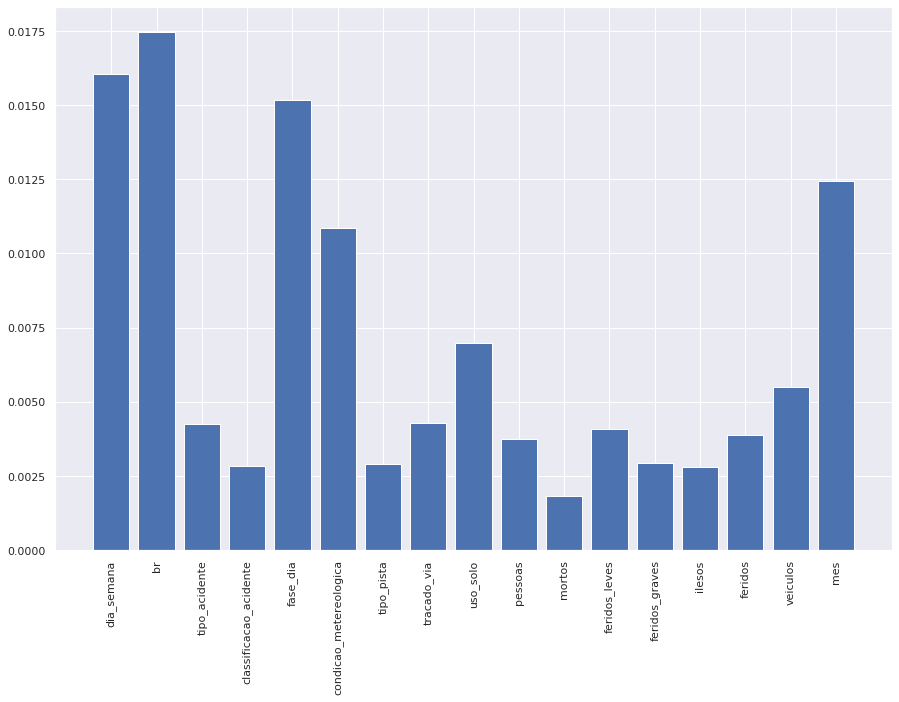

In [168]:
feature_importance = clf.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        clf.estimators_], 
                                        axis = 0)
plt.bar(X.columns, feature_importance_normalized)
plt.xticks(rotation = 90)

In [8]:
k_range = range(1, 100)
scores = {}
scores_list = []
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    scores[k] = metrics.accuracy_score(y_test, y_pred)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))
    
    knn_score = knn.score(X_test, y_test)
    #print('Score for k = ' + str(k) + ': ' + str(knn_score))
    
    k_scores.append(knn_score)

Text(0, 0.5, 'testing accuracy')

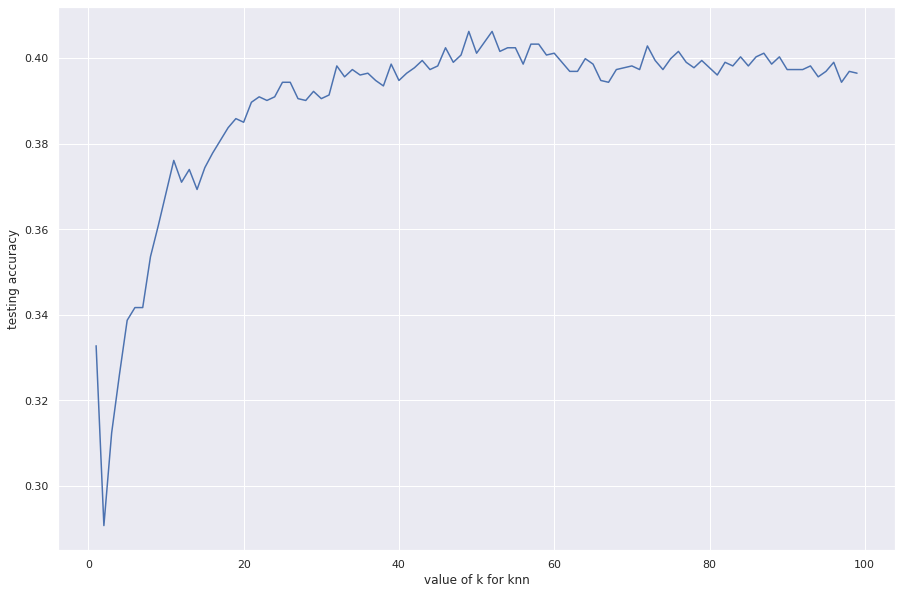

In [170]:
plt.plot(k_range, scores_list)
plt.xlabel('value of k for knn')
plt.ylabel('testing accuracy')

In [9]:
np_k_scores = np.asarray(k_scores)
best_k = np.argmax(np_k_scores) + 1
print('Best k to KNN Classifier: ' + str(best_k))

print('Best accuracy with knn: ' + str(max(scores_list)))

Best k to KNN Classifier: 49
Best accuracy with knn: 0.4061969439728353


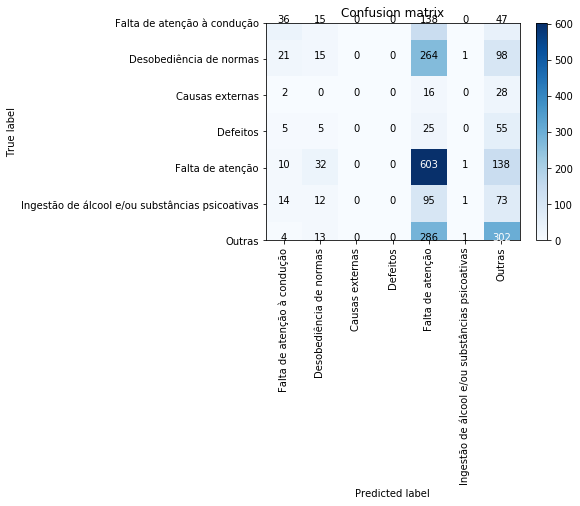

In [10]:
import itertools

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_pred = knn.predict(X_test)

causas_as_string = acidentes_prf.causa_acidente.unique().tolist()
confusion = confusion_matrix(y_test, y_pred, labels = causas_as_string)

plt.figure() 
plot_confusion_matrix(confusion, classes=causas_as_string)

#### Separação dos sets de treino e teste

In [139]:
model = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
       random_state=42, shuffle=True, tol=0.001, verbose=0, warm_start=False)

model.fit(X_train, y_train)

predicted = model.predict(X_test)

matrix = confusion_matrix(y_test, predicted)
print(matrix)

accuracy = model.score(X=X_test, y=y_test)
accuracy
# testar loss = modified hubber
# jobs
# penality
# random state



[[  0   0   0  46   0   0   0]
 [  0   0   0  90   0   0   0]
 [  0   0   0 399   0   0   0]
 [  0   0   0 784   0   0   0]
 [  0   0   0 236   0   0   0]
 [  0   0   0 195   0   0   0]
 [  0   0   0 606   0   0   0]]


0.33276740237691

In [140]:
model = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
       random_state=42, shuffle=True, tol=0.001, verbose=0, warm_start=False)

rbf_feature = RBFSampler(gamma=1, random_state=1)
X_features = rbf_feature.fit_transform(X_train)
X_features2 = rbf_feature.fit_transform(X_test)
model.fit(X_features, y_train)
model.score(X_features2, y_test)

0.32385398981324276

In [210]:
print(confusion)

[[ 29   3   0   0 160   0  44]
 [ 14   5   0   0 294   0  86]
 [  0   1   0   0  19   0  26]
 [  6   0   0   0  31   0  53]
 [  7   8   0   0 625   0 144]
 [ 15   2   0   0 122   0  56]
 [  2   2   0   0 327   0 275]]


In [83]:
np_k_scores = np.asarray(k_scores)
best_k = np.argmax(np_k_scores) + 1
print('Best k to KNN Classifier: ' + str(best_k))

Best k to KNN Classifier: 33


In [240]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [ ]:
confusion = confusion_matrix(y_test, y_pred, labels=)

In [151]:
acidentes_prf.causa_acidente.value_counts().tolist()

Falta de atenção                                   3917
Outras                                             3030
Desobediência de normas                            1994
Falta de atenção à condução                        1178
Ingestão de álcool e/ou substâncias psicoativas     977
Defeitos                                            448
Causas externas                                     232
Name: causa_acidente, dtype: int64

['Falta de atenção à condução',
 'Desobediência de normas',
 'Causas externas',
 'Defeitos',
 'Falta de atenção',
 'Ingestão de álcool e/ou substâncias psicoativas',
 'Outras']